In [1]:
from exp.utils import *
from exp.models import *
from exp.losses import *
from fastai.vision.all import *

In [2]:
lr = 1e-2
bs = (128, 64, 32)
epochs = 50
image_sizes = (64, 128, 244)
device = get_device()

Using the GPU!


In [3]:
p_data = get_data_path()
p_train_valid = p_data/"train_valid_images"
p_train_images = p_train_valid/"train_images"
p_valid_images = p_train_valid/"valid_images"
p_test_images  = p_data/"test_images"
p_dev_images = p_data/"dev_images"

In [4]:
# Load data
label = "Cardiomegaly"
train_df, valid_df, test_df = get_dataframes(include_labels=get_labels(), 
                                             small=False)
#print(train_df.shape, valid_df.shape, test_df.shape)
train_df = get_binary_df(label, train_df)
valid_df = get_binary_df(label, valid_df)
test_df  = get_binary_df(label, test_df)

complete_df = pd.concat([train_df, valid_df, test_df])
complete_df = complete_df.drop(columns=["Follow-up #", "Patient ID", "Patient Age", "Patient Gender", 
                   "View Position", "OriginalImage[Width", "Height]", 
                   "OriginalImagePixelSpacing[x", "y]", "No Finding"])

In [5]:
def label_func(fname):
    lbl = complete_df[complete_df["Image Index"] == fname.name]["Cardiomegaly"].values[0]
    return "C" if lbl > 0 else "No C"

def splitter_func(fn):
    return fn.parent.stem == "valid_images" 

In [6]:
train_label = train_df[[label]].values
neg_weights, pos_weights = compute_class_freqs(train_label)
neg_weights, pos_weights = torch.Tensor(neg_weights), torch.Tensor(pos_weights)
weights = torch.Tensor([neg_weights, pos_weights]).to(device)
print(neg_weights, pos_weights)

tensor([0.0203]) tensor([0.9797])


# Baseline

In [48]:
def baseline_dls():
    dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y     = label_func,
                       splitter  = RandomSplitter(),
                       item_tfms = Resize(224, 
                                          method="squish", 
                                          pad_mode="zeros"),
                       batch_tfms = [])
    return dblock.dataloaders(p_dev_images, bs=64)

In [9]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(224, 
                                      method="squish", 
                                      pad_mode="zeros"),
                   batch_tfms = [])
dls = dblock.dataloaders(p_dev_images, bs=64)

In [13]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.5202, 0.5202, 0.5202], device='cuda:0'),
 TensorImage([0.2552, 0.2552, 0.2552], device='cuda:0'))

In [12]:
model = xresnet18(n_out=dls.c)
learn = Learner(dls, 
                model, 
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, RocAucBinary()])
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.683720,0.692250,0.507692,0.545971,00:06
1,0.658772,0.671998,0.588462,0.616127,00:06
2,0.655517,0.801659,0.538462,0.577526,00:06
3,0.647169,0.701581,0.526923,0.587295,00:06
4,0.652311,1.255788,0.553846,0.620922,00:06
5,0.645493,1.024321,0.553846,0.637262,00:06
6,0.635086,4.221664,0.534615,0.539844,00:06
7,0.622283,0.632609,0.669231,0.701498,00:06
8,0.601930,1.659939,0.550000,0.561246,00:06
9,0.581320,1.113861,0.526923,0.692440,00:06


In [34]:
imagenet_stats 

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [35]:
my_stats = ([SUBSET_MEAN]*3, [SUBSET_STD]*3);my_stats

([0.50589985, 0.50589985, 0.50589985], [0.23221017, 0.23221017, 0.23221017])

# With Normalization - NOPE

In [36]:
def get_dls(bs=32, image_size=224):
    dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y     = label_func,
                       splitter  = RandomSplitter(),
                       item_tfms = [Resize(image_size, 
                                          method="squish", 
                                          pad_mode="zeros"),
                                    Normalize.from_stats(*my_stats)],
                       batch_tfms = [])
    return dblock, dblock.dataloaders(p_dev_images, bs=bs)

In [37]:
dblock, dls = get_dls(bs=64, image_size=224)

Could not do one pass in your dataloader, there is something wrong in it


In [29]:
dblock.summary(p_dev_images)

Setting-up type transforms pipelines
Found 1304 items
2 datasets of sizes 1044,260
Setting up Pipeline: PILBase.create
Setting up Pipeline: label_func -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/favi/.datasets/CRX8/dev_images/00002806_005.png
    applying PILBase.create gives
      PILImage mode=RGB size=1024x1024
  Pipeline: label_func -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/favi/.datasets/CRX8/dev_images/00002806_005.png
    applying label_func gives
      C
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=1024x1024, TensorCategory(0))


Found 1304 items
2 datasets of sizes 1044,260
Setting up Pipeline: PILBase.create
Setting up Pipeline: label_func -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipelin

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [23]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

# Progressive Resizing

In [38]:
def get_dls(bs=32, image_size=224):
    dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y     = label_func,
                       splitter  = RandomSplitter(),
                       item_tfms = [Resize(image_size, 
                                          method="squish", 
                                          pad_mode="zeros")],
                       batch_tfms = [])
    return dblock.dataloaders(p_dev_images, bs=bs)

In [39]:
dls = get_dls(bs=128, image_size=64)
model = xresnet18(n_out=dls.c)
learn = Learner(dls, 
                model, 
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, RocAucBinary()])
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.719360,0.743229,0.480769,0.509666,00:06
1,0.681320,1.204551,0.496154,0.614267,00:05
2,0.641943,0.666369,0.615385,0.687322,00:05
3,0.601035,0.605506,0.684615,0.745553,00:05
4,0.562170,0.600095,0.680769,0.757175,00:06


In [40]:
learn.dls = get_dls(bs=64, image_size=128)
learn.fine_tune(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.644788,0.813866,0.534615,0.679659,00:05


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.595945,0.644191,0.673077,0.723762,00:04
1,0.583890,1.568723,0.457692,0.741403,00:04
2,0.555923,1.240497,0.507692,0.758567,00:04
3,0.512015,0.522700,0.719231,0.813219,00:04
4,0.468236,0.535564,0.738462,0.819358,00:04


In [41]:
learn.dls = get_dls(bs=64, image_size=224)
learn.fine_tune(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.591159,7.906316,0.511538,0.625333,00:06


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.557945,0.648361,0.642308,0.739861,00:06
1,0.544892,0.997237,0.546154,0.765141,00:06
2,0.520444,2.063379,0.542308,0.639216,00:06
3,0.505527,3.945385,0.519231,0.614321,00:06
4,0.504802,1.004873,0.592308,0.679593,00:06
5,0.480954,0.537057,0.719231,0.808952,00:06
6,0.445078,1.778139,0.523077,0.750340,00:06
7,0.412546,0.615018,0.726923,0.799361,00:06
8,0.371388,0.542173,0.746154,0.848499,00:06
9,0.338049,0.479783,0.792308,0.850808,00:06


# MixUp

In [43]:
model = xresnet18(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                metrics=[accuracy, RocAucBinary()], cbs=MixUp())
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.740751,0.691755,0.546154,0.527929,00:05
1,0.700285,0.762568,0.476923,0.697403,00:05
2,0.672311,0.665550,0.615385,0.683705,00:06
3,0.652950,0.668462,0.611538,0.655716,00:05
4,0.636749,0.715343,0.584615,0.679376,00:05
5,0.618632,0.635034,0.646154,0.700961,00:05
6,0.597588,0.671172,0.673077,0.764943,00:06
7,0.573220,0.670919,0.707692,0.754625,00:05
8,0.557313,0.778133,0.603846,0.775676,00:05
9,0.526175,0.620273,0.696154,0.783563,00:05


# Label Smoothing

In [44]:
model = xresnet18(n_out=dls.c)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=[accuracy, RocAucBinary()])
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.755437,0.753425,0.476923,0.581535,00:05
1,0.700080,0.950525,0.476923,0.658444,00:05
2,0.673113,0.733263,0.507692,0.702621,00:05
3,0.652191,0.659933,0.619231,0.679851,00:05
4,0.633512,0.664702,0.615385,0.689160,00:06
5,0.616385,1.340033,0.519231,0.719699,00:05
6,0.592006,0.751485,0.657692,0.717445,00:05
7,0.566057,0.636667,0.696154,0.757946,00:05
8,0.542995,0.626229,0.692308,0.787536,00:05
9,0.514123,0.942196,0.584615,0.750119,00:05


# Augmentations

In [45]:
#item_tfms = Resize(image_size, method="squish", pad_mode="zeros")



def get_dls(bs=32, image_size=224):
    batch_tfms = [Brightness(), 
                  Contrast(),
                  RandomErasing(p=.25, max_count=2)] 
    
    dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y     = label_func,
                       splitter  = RandomSplitter(),
                       item_tfms = [Resize(image_size, 
                                          method="squish", 
                                          pad_mode="zeros")],
                       batch_tfms = batch_tfms)
    return dblock.dataloaders(p_dev_images, bs=bs)

In [46]:
dls = get_dls(bs=64, image_size=224)

In [47]:
model = xresnet18(n_out=dls.c)
learn = Learner(dls, 
                model, 
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, RocAucBinary()])
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.681530,0.688720,0.546154,0.594311,00:06
1,0.671588,0.668611,0.580769,0.646222,00:06
2,0.681705,0.682408,0.550000,0.618252,00:06
3,0.678268,0.707489,0.550000,0.650726,00:06
4,0.680060,0.916811,0.480769,0.575644,00:06
5,0.680669,0.725492,0.565385,0.651022,00:06
6,0.683318,0.742945,0.519231,0.658193,00:06
7,0.668252,0.707819,0.557692,0.706726,00:06
8,0.650675,0.656789,0.626923,0.680059,00:06
9,0.650486,0.679044,0.561538,0.765393,00:06


# Callbacks

In [53]:
sched = {'lr': SchedCos(3e-3, 1e-7)}
callbacks = [
    ParamScheduler(sched),
#    EarlyStoppingCallback(monitor="valid_loss",
#                          patience=15),
#    SaveModelCallback(monitor="valid_loss", 
#                      fname="resnet18_finetuned_v4"),
    ShowGraphCallback()
]

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.679454,0.712244,0.553846,0.637931,00:06
1,0.666872,0.731025,0.565385,0.609136,00:06
2,0.656353,0.637208,0.619231,0.678700,00:06
3,0.651796,0.758451,0.538462,0.687739,00:06
4,0.653978,0.823668,0.600000,0.666188,00:06
5,0.647406,0.895289,0.480769,0.706418,00:06
6,0.628472,2.907419,0.450000,0.616080,00:06
7,0.611268,1.552975,0.446154,0.706777,00:06
8,0.595243,0.586644,0.680769,0.760836,00:06
9,0.575918,1.014507,0.480769,0.628891,00:06


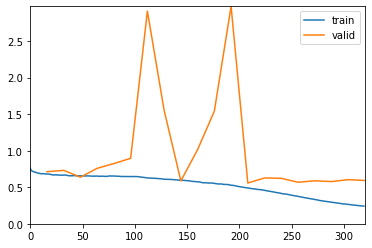

In [54]:
dls = baseline_dls()
model = xresnet18(n_out=dls.c)
learn = Learner(dls, 
                model, 
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, RocAucBinary()],
                cbs=callbacks)
learn.fit_one_cycle(20, 3e-3)

# Callbacks + MixUp

In [55]:
sched = {'lr': SchedCos(3e-3, 1e-7)}
callbacks = [
    ParamScheduler(sched),
#    EarlyStoppingCallback(monitor="valid_loss",
#                          patience=15),
#    SaveModelCallback(monitor="valid_loss", 
#                      fname="resnet18_finetuned_v4"),
    ShowGraphCallback(), 
    MixUp()
]

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.683339,0.689149,0.523077,0.627754,00:06
1,0.675101,0.693984,0.600000,0.613954,00:06
2,0.668002,0.707890,0.550000,0.612769,00:06
3,0.665876,2.232722,0.484615,0.594705,00:06
4,0.674578,1.370239,0.519231,0.585939,00:06
5,0.671176,0.706014,0.569231,0.622483,00:06
6,0.661444,0.709803,0.588462,0.700367,00:06
7,0.651665,0.621356,0.734615,0.731936,00:06
8,0.637655,0.826773,0.615385,0.694977,00:06
9,0.627189,1.757976,0.484615,0.723644,00:06


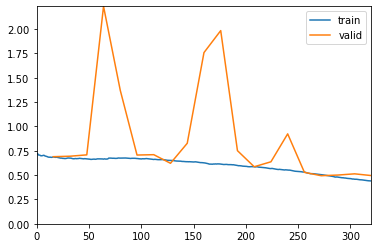

In [56]:
dls = baseline_dls()
model = xresnet18(n_out=dls.c)
learn = Learner(dls, 
                model, 
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, RocAucBinary()],
                cbs=callbacks)
learn.fit_one_cycle(20, 3e-3)

# Callbacks + MixUp + Label Smoothing

In [65]:
sched = {'lr': SchedExp(3e-4, 1e-7)}
callbacks = [
    ParamScheduler(sched),
    EarlyStoppingCallback(monitor="valid_loss",
                          patience=20),
#    SaveModelCallback(monitor="valid_loss", 
#                      fname="resnet18_finetuned_v4"),
    ShowGraphCallback(), 
    MixUp()
]

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.833820,0.717870,0.488462,0.549583,00:06
1,0.749563,0.731307,0.484615,0.538452,00:06
2,0.724942,0.800871,0.484615,0.561956,00:06
3,0.707260,0.807433,0.488462,0.605885,00:06
4,0.693275,0.685461,0.561538,0.660825,00:06
5,0.684461,0.729540,0.496154,0.680481,00:06
6,0.675850,0.745346,0.496154,0.673909,00:06
7,0.674317,0.674042,0.596154,0.640163,00:06
8,0.669448,0.747566,0.500000,0.661950,00:06
9,0.667175,1.034287,0.488462,0.554615,00:06


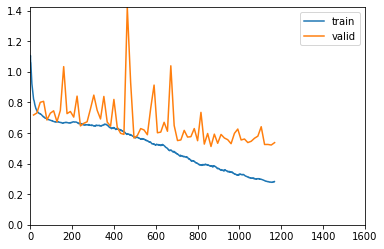

No improvement since epoch 53: early stopping


In [66]:
dls = get_dls(bs=64, image_size=224)
model = xresnet18(n_out=dls.c)
learn = Learner(dls, 
                model, 
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy, RocAucBinary()],
                cbs=callbacks)
learn.fit_one_cycle(100, 3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.719947,0.709619,0.500000,0.461753,00:10
1,0.698314,0.710728,0.530769,0.621625,00:10
2,0.678730,0.684069,0.588462,0.602932,00:10
3,0.676405,0.684483,0.584615,0.635036,00:10
4,0.673148,0.707961,0.557692,0.643048,00:10
5,0.668762,0.697917,0.557692,0.561510,00:10
6,0.673980,0.690753,0.569231,0.617946,00:10
7,0.674311,0.758277,0.542308,0.628627,00:10
8,0.673326,0.657912,0.673077,0.706842,00:10
9,0.679783,0.803203,0.476923,0.616403,00:10


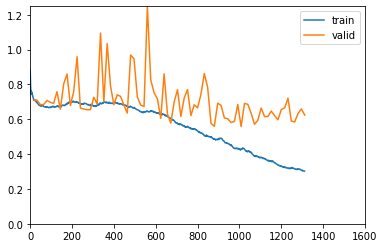

No improvement since epoch 62: early stopping


In [67]:
dls = get_dls(bs=64, image_size=224)
model = xresnet50(n_out=dls.c)
learn = Learner(dls, 
                model, 
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy, RocAucBinary()],
                cbs=callbacks)
learn.fit_one_cycle(100, 3e-3)

In [7]:
item_tfms = Resize(image_size, method="squish", pad_mode="zeros")

batch_tfms = [Brightness(), 
              Contrast(),
#              Warp(),
              RandomErasing(p=.25, max_count=2)
             ]  

TypeError: 'function' object is not subscriptable

In [ ]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(),
                   item_tfms = item_tfms,
                   batch_tfms = [])#batch_tfms)

#dsets = dblock.datasets(p_dev_images)

In [ ]:
#dls = dblock.dataloaders(p_dev_images, bs=bs)

In [ ]:
#dls.train.show_batch(max_n=27)

In [ ]:
#dls.valid.show_batch(max_n=27)

In [ ]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = FuncSplitter(splitter_func),
                   item_tfms = item_tfms,
                   batch_tfms = batch_tfms
                   )#

#dsets = dblock.datasets(p_train_valid)

In [ ]:
dls = dblock.dataloaders(p_train_valid, bs=bs)

In [ ]:
dls.train.show_batch(max_n=27)

In [ ]:
dls.valid.show_batch(max_n=27)

In [ ]:
#dls = dblock.dataloaders(p_train_valid, bs=bs)
#dls.show_batch(max_n=45)

In [ ]:
learn = cnn_learner(dls, resnet18, lr=1e-4, loss_func=CrossEntropyLossFlat(), 
                    metrics=[accuracy, Precision(), Recall(), RocAucBinary()])
learn.load(Path().cwd()/"models"/"resnet18_balanced_pretrain_v1")

In [ ]:
#learn.load(Path().cwd()/"models"/"resnet18_balanced_pretrain_v1")

In [ ]:
learn.lr_find()

In [ ]:
sched = {'lr': SchedCos(1e-3, 1e-7)}

In [ ]:
callbacks = [
    ParamScheduler(sched),
    EarlyStoppingCallback(monitor="valid_loss",
                          patience=15),
    SaveModelCallback(monitor="valid_loss", 
                      fname="resnet18_finetuned_v4"),
    ShowGraphCallback()
]

In [ ]:
learn.fine_tune(epochs, 
                freeze_epochs=5, 
                base_lr=1e-3, 
                cbs=callbacks)

In [ ]:
#learn.save("resnet18_finetuned_v1", with_opt=True)

In [ ]:
?learn.fine_tune

In [ ]:
#interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix()

In [ ]:
#interp.plot_top_losses(9)

In [ ]:
#learn.summary()
#learn.lr_find()

In [ ]:
learn.load(Path().cwd()/"models"/"resnet18_finetuned_v4")

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(9)

In [ ]:
learn.save("resnet18_v2", with_opt=True)

In [ ]:
test_dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                        get_items = get_image_files,
                        get_y     = label_func,
                        item_tfms = item_tfms[0])

In [ ]:
test_dls = test_dblock.dataloaders(p_test_images, bs=bs)
test_dls.show_batch(max_n=27)

In [ ]:
test_learn = cnn_learner(test_dls, resnet18, lr=1e-4, loss_func=CrossEntropyLossFlat(), 
                    metrics=[accuracy, Precision(), Recall(), RocAucBinary()])

In [ ]:
test_learn.model = learn.model

In [ ]:
interp = ClassificationInterpretation.from_learner(test_learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(9)

In [ ]:
interp

In [ ]:
learn.summary()

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(epochs, 
                base_lr=0.002, 
                freeze_epochs=0, 
                lr_mult=100, 
                pct_start=0.3, 
                div=5.0, 
                div_final=100000.0, 
                wd=None, moms=None, cbs=None, reset_opt=False)


In [ ]:
#learn.lr_find()

In [ ]:
learn.save("untrained_resnet18", with_opt=True)

In [ ]:
learn.fit_one_cycle(epochs, lr_max=lr)

In [ ]:
learn.fine_tune(3)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused()

In [ ]:
interp.plot_top_losses(9)